In [1]:
# Setup
import pandas as pd
import numpy as np
import os
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load Precalculated Features

In [15]:
# Create a numpy array containing all the calculated features Poseformer (HRNet output)
# Exclude fields 0 (identifiers), 1 (number of cycles, duplicate), 2 (orientation), 3 (framerate)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/results/results-poseformer-20230604_3d.csv')
df_calc.drop(['Unnamed: 0', 'n', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,...,neck_3d_max_y_acc_stand2sit,ank_to_hip_dist_sit_3d,ank_to_hip_dist_stand_3d,knee_to_hip_dist_sit_3d,knee_to_hip_dist_stand_3d,height_3d,lknee_angle_first_sit_3d,rknee_angle_first_sit_3d,lknee_angle_first_stand_3d,rknee_angle_first_stand_3d
0,kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5,5.000000,-0.083333,1.00,...,8.662610,1.323744,1.663332,1.496001,1.521675,1.594991,238.587860,128.60143,193.61642,166.17770
1,GjPHiGli,14.033333,-0.066667,0.36,0.247117,0.030709,5,5.266667,-0.791667,0.95,...,5.645724,1.720683,1.897206,1.382583,1.394735,1.656933,106.175110,235.75148,165.18759,165.08733
2,RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5,4.333333,-1.166667,1.15,...,7.442025,0.819094,0.748246,1.205347,0.703840,1.571508,254.212970,253.65948,173.26003,173.93872
3,gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5,3.900000,-0.866667,1.28,...,6.938134,1.238144,1.155679,1.259590,0.923143,1.349029,95.654854,84.81681,212.53954,195.62816
4,xEIsrkiR,12.266667,-0.500000,0.41,0.972420,0.342664,5,2.233333,-2.000000,2.24,...,32.851835,0.957589,1.094586,0.556713,0.686454,1.507073,123.651610,248.94016,172.28114,160.91620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4,5.966667,-1.311111,0.67,...,8.877083,1.055738,1.026740,0.900768,1.066869,1.619607,89.533646,266.95810,190.02066,154.12817
380,8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5,4.000000,0.100000,1.25,...,11.885703,0.952726,0.550644,1.275098,1.308036,1.506827,249.733640,118.27622,221.42905,195.31001
381,PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4,4.900000,-1.655556,0.82,...,5.925983,0.752801,0.931558,1.016200,1.141192,1.566733,94.272920,92.37152,166.02623,192.59793
382,q8FyLMSn,6.400000,0.000000,0.78,0.068638,0.042368,5,3.633333,0.175000,1.38,...,19.781118,0.891696,0.785821,1.570418,1.147785,1.531170,254.278470,122.19201,153.95439,192.81271


### Load Survey Data (labels)

In [10]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [16]:
# join the dataframes by subjectId - precalculated features only
df_join = df_calc.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit_3d,ank_to_hip_dist_stand_3d,knee_to_hip_dist_sit_3d,knee_to_hip_dist_stand_3d,height_3d,lknee_angle_first_sit_3d,rknee_angle_first_sit_3d,lknee_angle_first_stand_3d,rknee_angle_first_stand_3d,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.323744,1.663332,1.496001,1.521675,1.594991,238.587860,128.601425,193.616425,166.177704,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.720683,1.897206,1.382583,1.394735,1.656933,106.175110,235.751480,165.187592,165.087326,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,0.819094,0.748246,1.205347,0.703840,1.571508,254.212967,253.659485,173.260025,173.938721,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.238144,1.155679,1.259590,0.923143,1.349029,95.654854,84.816811,212.539536,195.628159,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.957589,1.094586,0.556713,0.686454,1.507073,123.651611,248.940155,172.281143,160.916199,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,1.055738,1.026740,0.900768,1.066869,1.619607,89.533646,266.958099,190.020660,154.128174,NaN
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,0.952726,0.550644,1.275098,1.308036,1.506827,249.733643,118.276222,221.429047,195.310013,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.752801,0.931558,1.016199,1.141191,1.566733,94.272919,92.371521,166.026230,192.597931,NaN


In [17]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit_3d,ank_to_hip_dist_stand_3d,knee_to_hip_dist_sit_3d,knee_to_hip_dist_stand_3d,height_3d,lknee_angle_first_sit_3d,rknee_angle_first_sit_3d,lknee_angle_first_stand_3d,rknee_angle_first_stand_3d,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.323744,1.663332,1.496001,1.521675,1.594991,238.587860,128.601425,193.616425,166.177704,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.720683,1.897206,1.382583,1.394735,1.656933,106.175110,235.751480,165.187592,165.087326,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,0.819094,0.748246,1.205347,0.703840,1.571508,254.212967,253.659485,173.260025,173.938721,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.238144,1.155679,1.259590,0.923143,1.349029,95.654854,84.816811,212.539536,195.628159,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.957589,1.094586,0.556713,0.686454,1.507073,123.651611,248.940155,172.281143,160.916199,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,1.055738,1.026740,0.900768,1.066869,1.619607,89.533646,266.958099,190.020660,154.128174,1.0
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,0.952726,0.550644,1.275098,1.308036,1.506827,249.733643,118.276222,221.429047,195.310013,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.752801,0.931558,1.016199,1.141191,1.566733,94.272919,92.371521,166.026230,192.597931,1.0


In [11]:
# join the dataframes by subjectId - raw 2d keypoints only
df_join2d = df_kp2d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join2d

,0,1,2,3,4,5,6,7,8,9,...,51365,51366,51367,51368,51369,51370,51371,51372,51373,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,315.685852,753.182617,274.055603,758.386353,378.131226,831.239319,326.093414,1018.575378,357.316101,747.978821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,456.260345,829.245667,393.725159,844.879456,581.330688,938.682251,534.429321,1235.724365,518.795532,813.611877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,112.074158,559.071594,126.040131,568.382263,247.078568,605.624817,247.078568,754.595215,98.108185,549.760925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,184.985413,261.598724,169.771530,257.795258,136.808105,283.151733,152.021988,333.864685,200.199295,265.402191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,260.938232,641.753784,168.722412,641.753784,298.909454,771.940796,179.571335,880.429993,353.154053,641.753784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,558.194092,756.626953,447.130249,781.307861,521.172852,1250.244263,521.172852,1447.691162,669.257996,731.946106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8elUiJYv,535.904724,1174.302490,487.117706,1182.433594,600.954102,1361.319336,584.691772,1670.303955,584.691772,1166.171265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,412.282166,884.938721,348.439545,906.219543,348.439545,1204.151611,433.563019,1374.398560,476.124756,863.657837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
# all videos from the new clinical trial have OA=1 
df_join2d = df_join2d.fillna(value={'OA_check': 1})
df_join2d

,0,1,2,3,4,5,6,7,8,9,...,51365,51366,51367,51368,51369,51370,51371,51372,51373,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,315.685852,753.182617,274.055603,758.386353,378.131226,831.239319,326.093414,1018.575378,357.316101,747.978821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,456.260345,829.245667,393.725159,844.879456,581.330688,938.682251,534.429321,1235.724365,518.795532,813.611877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,112.074158,559.071594,126.040131,568.382263,247.078568,605.624817,247.078568,754.595215,98.108185,549.760925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,184.985413,261.598724,169.771530,257.795258,136.808105,283.151733,152.021988,333.864685,200.199295,265.402191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,260.938232,641.753784,168.722412,641.753784,298.909454,771.940796,179.571335,880.429993,353.154053,641.753784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,558.194092,756.626953,447.130249,781.307861,521.172852,1250.244263,521.172852,1447.691162,669.257996,731.946106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8elUiJYv,535.904724,1174.302490,487.117706,1182.433594,600.954102,1361.319336,584.691772,1670.303955,584.691772,1166.171265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,412.282166,884.938721,348.439545,906.219543,348.439545,1204.151611,433.563019,1374.398560,476.124756,863.657837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Data validation 

In [18]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [19]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [20]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
84.0
306
67.0
39
8.0
39
9.0


#### Normalization

In [21]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np) + 0.00001) # for numerical stability
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [79]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [99]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 529]) torch.Size([64])
tensor([[ 7.0000e+00,  2.1667e-01,  7.1000e-01,  ...,  1.0991e+02,
          1.9182e+02,  2.0715e+02],
        [ 1.0633e+01, -8.3333e-03,  4.7000e-01,  ...,  2.5617e+02,
          1.9233e+02,  1.9878e+02],
        [ 1.5033e+01, -3.8333e-01,  3.3000e-01,  ...,  9.9615e+01,
          1.9372e+02,  1.9285e+02],
        ...,
        [ 1.2400e+01, -3.4167e-01,  4.0000e-01,  ...,  9.0528e+01,
          1.9149e+02,  1.9876e+02],
        [ 1.2833e+01, -1.3333e-01,  3.9000e-01,  ...,  1.1011e+02,
          1.7762e+02,  1.7445e+02],
        [ 1.5000e+01, -4.3333e-01,  3.3000e-01,  ...,  2.7958e+02,
          1.7865e+02,  1.6621e+02]]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


#### Create a manually curated data set

In [100]:
#potential_cols = df_join.filter(regex=(".*(time|speed|trunk).*")).columns.values
# potential_cols = df_join.filter(regex=(".*3d.*")).columns.values
# for p in potential_cols:
#     print(p)
cols_manual = ['time_sit2stand',
'speed_sit2stand',
'time_sd_sit2stand',
'speed_sd_sit2stand',
'time_stand2sit',
'speed_stand2sit',
'time_sd_stand2sit',
'speed_sd_stand2sit',
'trunk_lean_range_mean',
'trunk_lean_sd',
'trunk_lean_max',
'trunk_lean_min',
'trunk_lean_ang_vel',
'trunk_lean_ang_acc',
'trunk_lean_max_ang_vel',
'trunk_lean_max_ang_acc',
'trunk_lean_min_ang_vel',
'trunk_lean_min_ang_acc',
'trunk_lean_range_mean_sit2stand',
'trunk_lean_sd_sit2stand',
'trunk_lean_max_sit2stand',
'trunk_lean_min_sit2stand',
'trunk_lean_ang_vel_sit2stand',
'trunk_lean_ang_acc_sit2stand',
'trunk_lean_max_ang_vel_sit2stand',
'trunk_lean_max_ang_acc_sit2stand',
'trunk_lean_min_ang_vel_sit2stand',
'trunk_lean_min_ang_acc_sit2stand',
'trunk_lean_range_mean_stand2sit',
'trunk_lean_sd_stand2sit',
'trunk_lean_max_stand2sit',
'trunk_lean_min_stand2sit',
'trunk_lean_ang_vel_stand2sit',
'trunk_lean_ang_acc_stand2sit',
'trunk_lean_max_ang_vel_stand2sit',
'trunk_lean_max_ang_acc_stand2sit',
'trunk_lean_min_ang_vel_stand2sit',
'trunk_lean_min_ang_acc_stand2sit',
'lknee_angle_first_sit_3d',
'rknee_angle_first_sit_3d',
'lknee_angle_first_stand_3d',
'rknee_angle_first_stand_3d',
'pelvic_3d_avg_speed',
'pelvic_3d_min_speed',
'pelvic_3d_max_speed',
'pelvic_3d_avg_acc',
'pelvic_3d_min_acc',
'pelvic_3d_max_acc',
'pelvic_3d_avg_y_speed',
'pelvic_3d_min_y_speed',
'pelvic_3d_max_y_speed',
'pelvic_3d_avg_y_acc',
'pelvic_3d_min_y_acc',
'pelvic_3d_max_y_acc',
'OA_check']
df_manual = df_join.loc[:,cols_manual]

In [101]:
# Create separate loader with manually selected columns

train_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

#### Create dataloaders with upsampling 

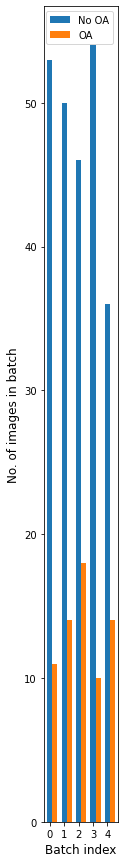

Avg Proportion of No OA per batch: 4.78
Avg Proportion of OA per batch: 1.3399999999999999
Num. unique images seen: 207/306


In [102]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

<ipython-input-103-8623099a84a5>:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  class_weights_all = class_weights[labels]


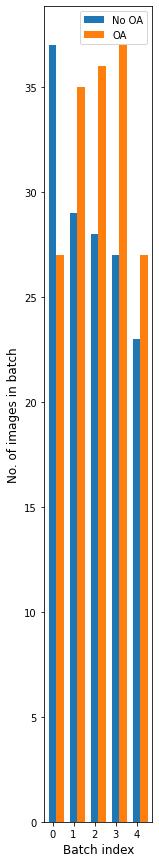

Avg Proportion of No OA per batch: 2.88
Avg Proportion of OA per batch: 3.2399999999999998
Num. unique images seen: 133/306


In [103]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [104]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 529
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.6632, train_acc = 78.4314, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 1, loss = 0.6128, train_acc = 79.0850, val_acc = 79.4872, train_pos = 0.9804, val_pos = 0.0000
Epoch 2, loss = 0.5273, train_acc = 79.4118, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 3, loss = 0.5883, train_acc = 79.4118, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 4, loss = 0.5428, train_acc = 79.4118, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 5, loss = 0.4588, train_acc = 79.4118, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 6, loss = 0.4454, train_acc = 79.4118, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 7, loss = 0.5290, train_acc = 80.3922, val_acc = 79.4872, train_pos = 2.9412, val_pos = 0.0000
Epoch 8, loss = 0.3389, train_acc = 80.7190, val_acc = 79.4872, train_pos = 3.2680, val_pos = 0.0000
Epoch 9, loss = 0.5076, train_acc = 81.0458, val_acc = 82.0513, train_pos = 2.9412, val_pos

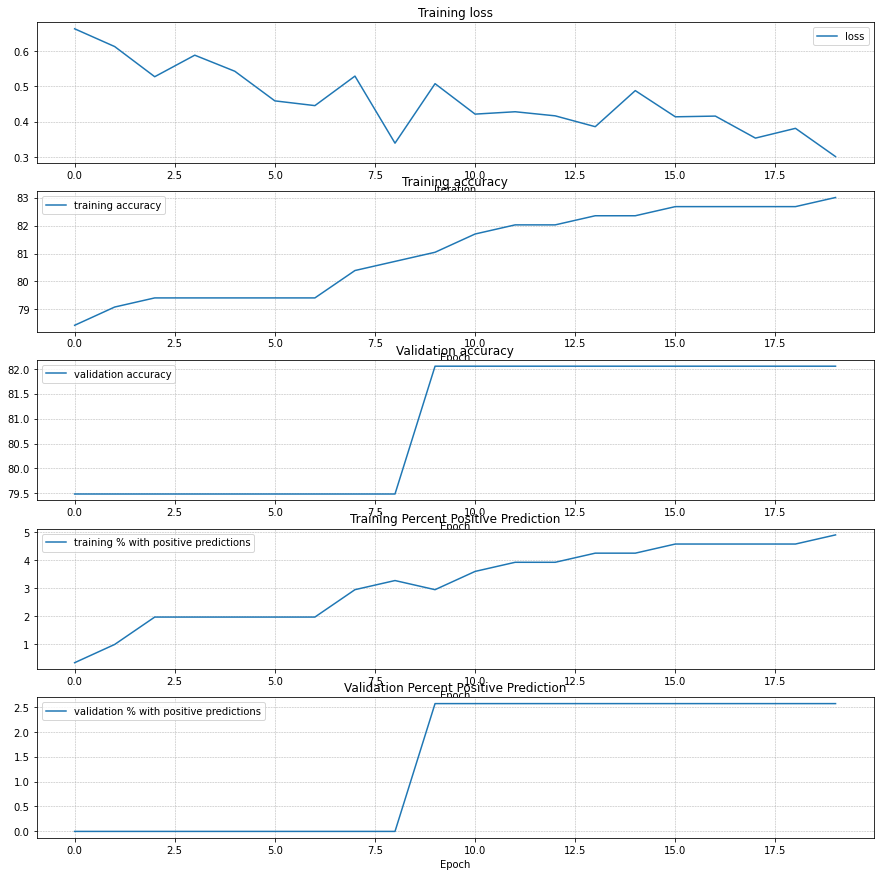

In [105]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [106]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 529
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.6740, train_acc = 53.2680, val_acc = 82.0513, train_pos = 8.1699, val_pos = 7.6923
Epoch 1, loss = 0.6003, train_acc = 57.8431, val_acc = 76.9231, train_pos = 13.0719, val_pos = 12.8205
Epoch 2, loss = 0.5797, train_acc = 68.3007, val_acc = 76.9231, train_pos = 19.2810, val_pos = 17.9487
Epoch 3, loss = 0.6222, train_acc = 72.8758, val_acc = 79.4872, train_pos = 25.1634, val_pos = 20.5128
Epoch 4, loss = 0.5595, train_acc = 70.9150, val_acc = 76.9231, train_pos = 28.1046, val_pos = 23.0769
Epoch 5, loss = 0.5626, train_acc = 70.9150, val_acc = 76.9231, train_pos = 24.8366, val_pos = 23.0769
Epoch 6, loss = 0.5640, train_acc = 68.6275, val_acc = 76.9231, train_pos = 23.5294, val_pos = 23.0769
Epoch 7, loss = 0.5519, train_acc = 69.9346, val_acc = 79.4872, train_pos = 30.3922, val_pos = 20.5128
Epoch 8, loss = 0.5725, train_acc = 77.1242, val_acc = 82.0513, train_pos = 36.9281, val_pos = 23.0769
Epoch 9, loss = 0.5563, train_acc = 81.3725, val_acc = 82.0513, train_pos =

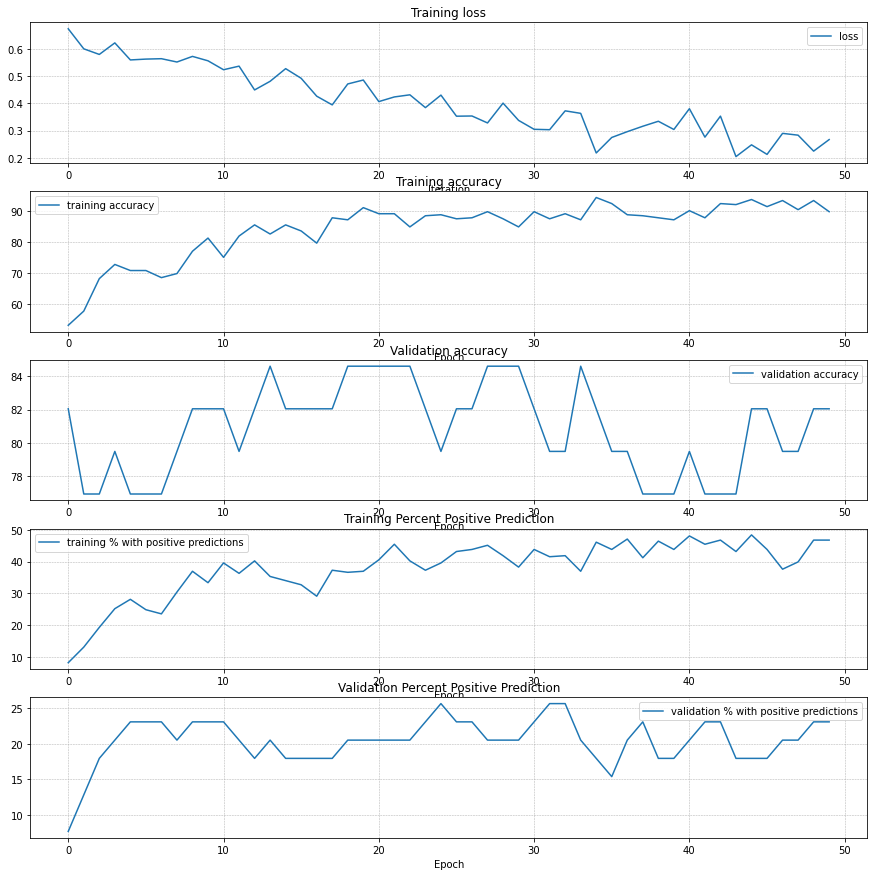

In [107]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [108]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 529
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 0.6109, train_acc = 54.1841, val_acc = 79.4872, train_pos = 5.8577, val_pos = 15.3846
Epoch 1, loss = 0.6317, train_acc = 63.3891, val_acc = 79.4872, train_pos = 17.1548, val_pos = 15.3846
Epoch 2, loss = 0.5243, train_acc = 71.1297, val_acc = 79.4872, train_pos = 28.2427, val_pos = 20.5128
Epoch 3, loss = 0.5488, train_acc = 76.1506, val_acc = 79.4872, train_pos = 34.1004, val_pos = 20.5128
Epoch 4, loss = 0.4984, train_acc = 80.1255, val_acc = 82.0513, train_pos = 37.6569, val_pos = 23.0769
Epoch 5, loss = 0.4535, train_acc = 83.4728, val_acc = 82.0513, train_pos = 40.1674, val_pos = 23.0769
Epoch 6, loss = 0.4143, train_acc = 84.3096, val_acc = 82.0513, train_pos = 41.0042, val_pos = 23.0769
Epoch 7, loss = 0.5642, train_acc = 84.5188, val_acc = 79.4872, train_pos = 41.6318, val_pos = 25.6410
Epoch 8, loss = 0.5106, train_acc = 85.1464, val_acc = 79.4872, train_pos = 42.6778, val_pos = 25.6410
Epoch 9, loss = 0.4235, train_acc = 86.1925, val_acc = 79.4872, train_pos 

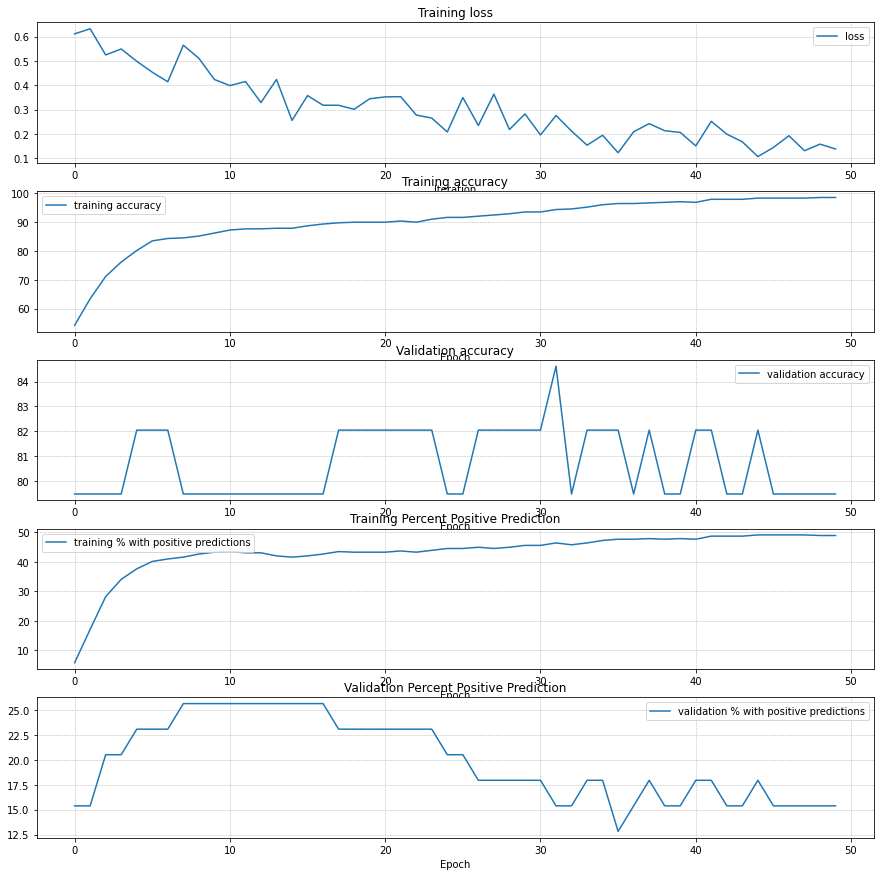

In [109]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [110]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [111]:
input_size = 529
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 248.7530, train_acc = 21.8954, val_acc = 35.8974, train_pos = 98.6928, val_pos = 74.3590
Epoch 1, loss = 251.3276, train_acc = 63.0719, val_acc = 82.0513, train_pos = 26.7974, val_pos = 2.5641
Epoch 2, loss = 225.6116, train_acc = 78.1046, val_acc = 76.9231, train_pos = 1.9608, val_pos = 2.5641
Epoch 3, loss = 118.9162, train_acc = 78.4314, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 4, loss = 43.9984, train_acc = 79.0850, val_acc = 76.9231, train_pos = 4.9020, val_pos = 7.6923
Epoch 5, loss = 39.4323, train_acc = 73.8562, val_acc = 71.7949, train_pos = 16.0131, val_pos = 28.2051
Epoch 6, loss = 50.2941, train_acc = 72.2222, val_acc = 71.7949, train_pos = 20.9150, val_pos = 12.8205
Epoch 7, loss = 33.5268, train_acc = 77.7778, val_acc = 76.9231, train_pos = 12.0915, val_pos = 7.6923
Epoch 8, loss = 18.4743, train_acc = 77.7778, val_acc = 69.2308, train_pos = 9.4771, val_pos = 15.3846
Epoch 9, loss = 17.3129, train_acc = 68.6275, val_acc = 64.1026, trai

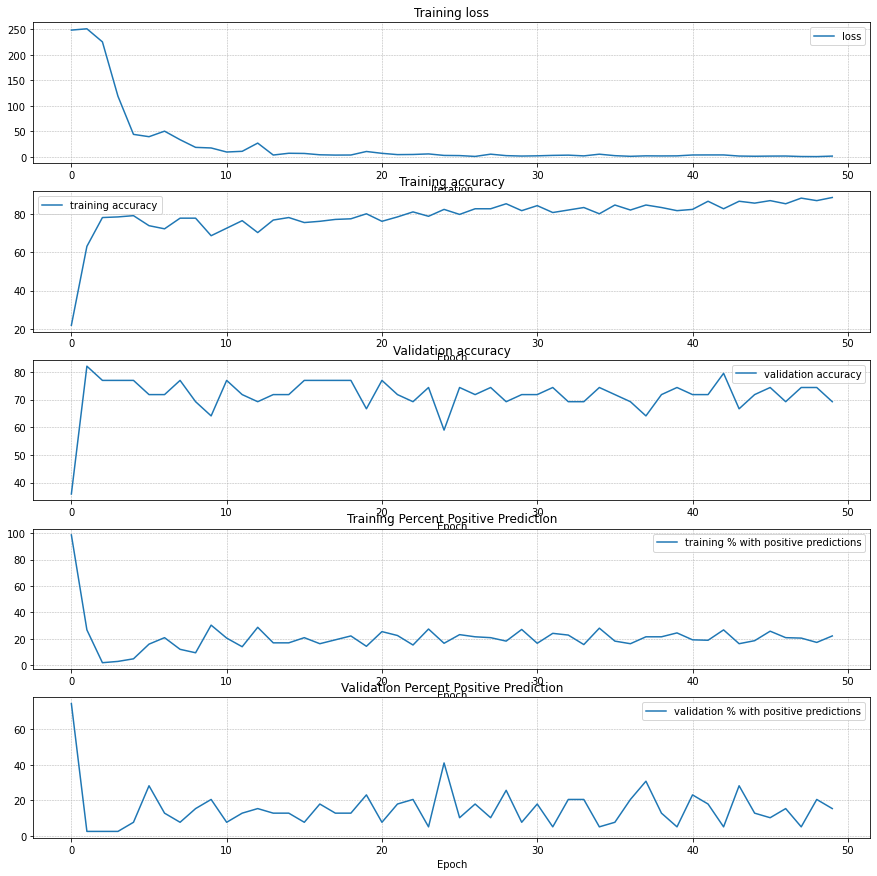

In [112]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized

In [113]:
input_size = 54
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=50)

Epoch 0, loss = 43.6869, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 43.2154, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 2, loss = 69.5859, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 3, loss = 56.1944, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 4, loss = 56.1506, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 5, loss = 48.3933, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 6, loss = 30.6941, train_acc = 77.7778, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 7, loss = 12.9987, train_acc = 77.4510, val_acc = 82.0513, train_pos = 0.6536, val_pos = 2.5641
Epoch 8, loss = 30.0052, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.6536, val_pos = 5.1282
Epoch 9, loss = 28.7244, train_acc = 77.1242, val_acc = 76.9231, train_pos = 0.980

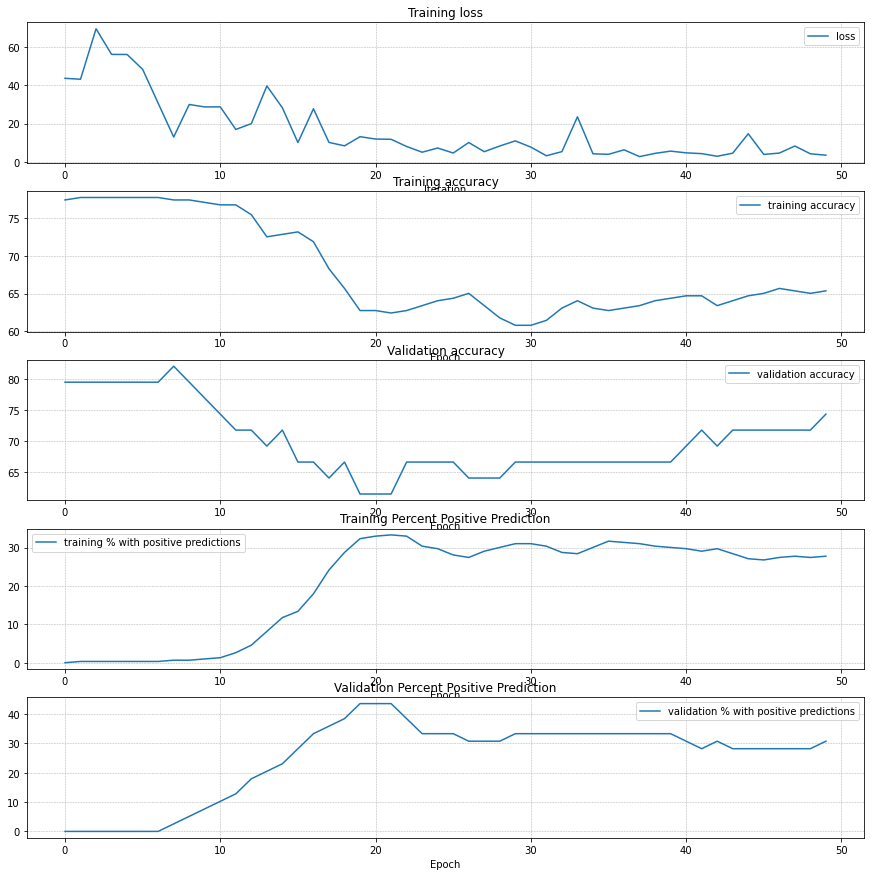

In [114]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized, oversampled

In [115]:
train_manual = df_manual.iloc[:NUM_TRAIN+NUM_VAL]

index_0 = train_manual.index[train_manual['OA_check'] == 0.0].tolist()
class_0 = train_manual.loc[index_0]
index_1 = train_manual.index[train_manual['OA_check'] == 1.0].tolist()
class_1 = train_manual.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_m_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_m_over = train_m_over.sample(frac = 1)

NUM_TRAIN_M_OS = len(train_m_over)

train_m = CustomDataset(dataframe=train_m_over)
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_M_OS)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

input_size = 54 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=200)

Epoch 0, loss = 24.6695, train_acc = 52.0522, val_acc = 35.8974, train_pos = 18.0970, val_pos = 74.3590
Epoch 1, loss = 12.4349, train_acc = 49.4403, val_acc = 53.8462, train_pos = 78.5448, val_pos = 51.2821
Epoch 2, loss = 7.2114, train_acc = 52.9851, val_acc = 51.2821, train_pos = 33.5821, val_pos = 43.5897
Epoch 3, loss = 4.9484, train_acc = 55.5970, val_acc = 46.1538, train_pos = 54.4776, val_pos = 64.1026
Epoch 4, loss = 22.3652, train_acc = 51.8657, val_acc = 46.1538, train_pos = 48.1343, val_pos = 58.9744
Epoch 5, loss = 1.7509, train_acc = 53.9179, val_acc = 48.7179, train_pos = 63.2463, val_pos = 46.1538
Epoch 6, loss = 3.8044, train_acc = 52.4254, val_acc = 38.4615, train_pos = 44.5896, val_pos = 66.6667
Epoch 7, loss = 3.2621, train_acc = 56.3433, val_acc = 48.7179, train_pos = 52.2388, val_pos = 46.1538
Epoch 8, loss = 3.8795, train_acc = 55.9701, val_acc = 53.8462, train_pos = 51.4925, val_pos = 51.2821
Epoch 9, loss = 4.3378, train_acc = 55.5970, val_acc = 51.2821, train_

Epoch 79, loss = 0.8937, train_acc = 69.0299, val_acc = 79.4872, train_pos = 44.0299, val_pos = 15.3846
Epoch 80, loss = 0.5396, train_acc = 64.9254, val_acc = 64.1026, train_pos = 35.8209, val_pos = 41.0256
Epoch 81, loss = 0.4859, train_acc = 66.0448, val_acc = 84.6154, train_pos = 47.3881, val_pos = 20.5128
Epoch 82, loss = 1.0040, train_acc = 68.0970, val_acc = 79.4872, train_pos = 42.3507, val_pos = 15.3846
Epoch 83, loss = 0.8221, train_acc = 63.9925, val_acc = 71.7949, train_pos = 44.5896, val_pos = 38.4615
Epoch 84, loss = 1.0791, train_acc = 62.8731, val_acc = 82.0513, train_pos = 44.5896, val_pos = 17.9487
Epoch 85, loss = 1.2718, train_acc = 65.1119, val_acc = 76.9231, train_pos = 43.0970, val_pos = 23.0769
Epoch 86, loss = 0.6330, train_acc = 68.0970, val_acc = 82.0513, train_pos = 41.6045, val_pos = 17.9487
Epoch 87, loss = 0.8388, train_acc = 65.4851, val_acc = 71.7949, train_pos = 41.6045, val_pos = 33.3333
Epoch 88, loss = 0.7028, train_acc = 66.7910, val_acc = 82.0513,

Epoch 159, loss = 0.4158, train_acc = 67.1642, val_acc = 66.6667, train_pos = 40.2985, val_pos = 53.8462
Epoch 160, loss = 0.3146, train_acc = 69.9627, val_acc = 79.4872, train_pos = 52.7985, val_pos = 30.7692
Epoch 161, loss = 0.4934, train_acc = 69.9627, val_acc = 79.4872, train_pos = 41.2313, val_pos = 10.2564
Epoch 162, loss = 0.5951, train_acc = 69.4030, val_acc = 79.4872, train_pos = 35.4478, val_pos = 25.6410
Epoch 163, loss = 0.4115, train_acc = 71.8284, val_acc = 84.6154, train_pos = 42.7239, val_pos = 20.5128
Epoch 164, loss = 0.5072, train_acc = 72.3881, val_acc = 79.4872, train_pos = 42.1642, val_pos = 15.3846
Epoch 165, loss = 0.6161, train_acc = 73.3209, val_acc = 79.4872, train_pos = 35.6343, val_pos = 35.8974
Epoch 166, loss = 0.4857, train_acc = 71.4552, val_acc = 82.0513, train_pos = 46.4552, val_pos = 17.9487
Epoch 167, loss = 0.6064, train_acc = 73.8806, val_acc = 82.0513, train_pos = 38.8060, val_pos = 17.9487
Epoch 168, loss = 0.4589, train_acc = 72.5746, val_acc 

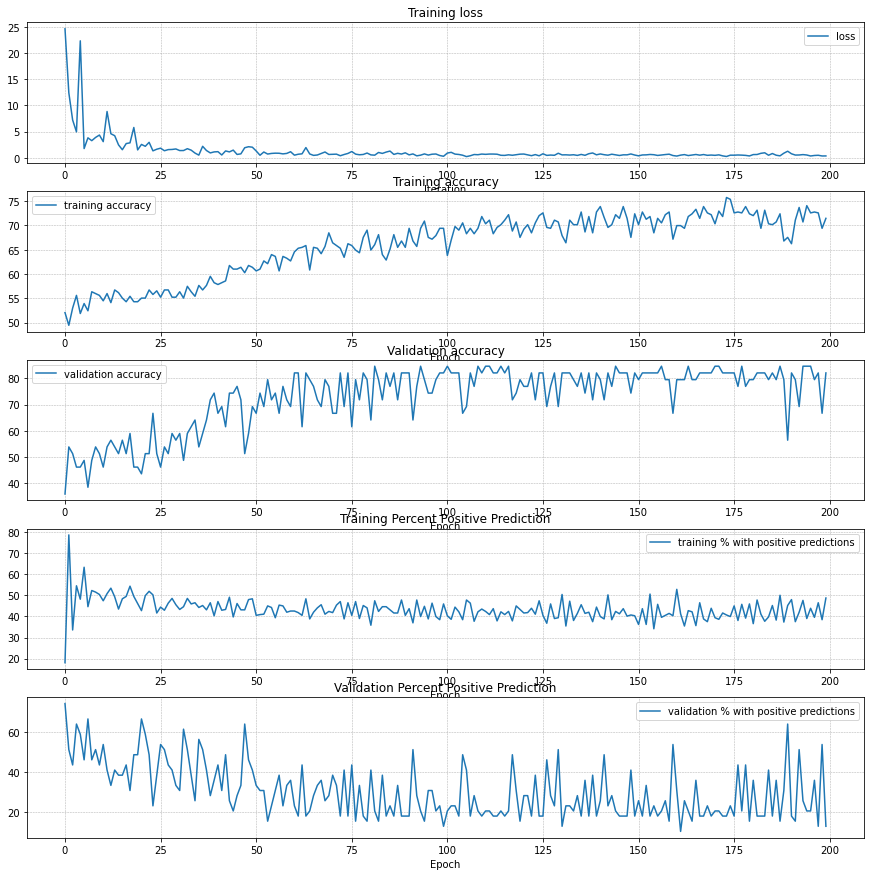

In [116]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss